## Model for predicting the overall of the football players

### Project by Amir Mastikbayev

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.1 Introduction to the case

Each football player was assessed by EA sports company that are the producers of the popular video games such as FIFA till 2023 and FC since 2024. The features of the football players are assessed by perfomance of the football players in the real life mathces.

Each infield player has 6 main features such as Pace, Shooting, Passing, Dribbling, Defending and Physical. Each of those features are calculated with the average of subfeatures: Pace is calculated by the average between acceleration and Sprint Speed, Shooting by Attacking position, finishing, shot power, long shots, volleys and penalties. etc.

Goalkeepers have different features as they are assessed by diving, positioning, reaction, etc. Thus we decided to exclude goalkeepers from assessment.

Here is a figure showing what every row of the data has as their features

In [3]:
# Displaying the features of the football player - Kylian Mbappe

#from IPython.display import display
#from PIL import Image

#display(Image.open("mbappe.jpg"))

## 2. Setup

We start by importing the necessary libraries.

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## 3. Data Loading and Preparation

In this step, we specify the path of the dataset and load it into a pandas DataFrame. We then select relevant features for modeling and exclude goalkeepers due to the nature of their attributes differing significantly from outfield players.

In [23]:
"""path = r'/Users/amastikbayev/Desktop'

name = 'male_players.csv'

full_file_path = path + '/' + name"""

df = pd.read_csv("male_players.csv", sep = ',',low_memory=False)

# Selecting relevant columns
selected_columns = [
    'player_id', 'fifa_version', 'long_name', 'overall', 'potential', 'value_eur',
    'wage_eur', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'nationality_id',
    'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation',
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'player_positions'
]

df = df[selected_columns]

df = df[~df['player_positions'].str.contains('GK', na=False)]

df.head()

,player_id,fifa_version,long_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,...,weak_foot,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,player_positions
0,231747,24.0,Kylian Mbappé Lottin,91,94,181500000.0,230000.0,24,182,75,...,4,5,5,97.0,90.0,80.0,92.0,36.0,78.0,"ST, LW"
1,239085,24.0,Erling Braut Haaland,91,94,185000000.0,340000.0,22,195,94,...,3,3,5,89.0,93.0,66.0,80.0,45.0,88.0,ST
2,192985,24.0,Kevin De Bruyne,91,91,103000000.0,350000.0,32,181,75,...,5,4,5,72.0,88.0,94.0,87.0,65.0,78.0,"CM, CAM"
3,158023,24.0,Lionel Andrés Messi Cuccittini,90,90,41000000.0,23000.0,36,169,67,...,4,4,5,80.0,87.0,90.0,94.0,33.0,64.0,"CF, CAM"
4,165153,24.0,Karim Benzema,90,90,51000000.0,95000.0,35,185,81,...,4,4,5,79.0,88.0,83.0,87.0,39.0,78.0,"CF, ST"


## 4. Data Encoding and Splitting

We encode categorical variables (e.g., preferred foot) using one-hot encoding. Then, we split the data by FIFA version into training, testing, and prediction sets. We will use FIFA 20-22 data for training, FIFA 23 data for testing, and FIFA 24 for future value prediction.

In [8]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['preferred_foot'], drop_first=True)

# Split dataset into training, testing, and prediction sets
train_data = df_encoded[df_encoded['fifa_version'].isin([20.0, 21.0, 22.0])]
test_data = df_encoded[df_encoded['fifa_version'] == 23.0]
predict_data = df_encoded[df_encoded['fifa_version'] == 24.0]

#train_data.shape
#test_data.shape
#predict_data.shape

## 5. Exploratory Data Analysis (EDA)

### 5.1 Correlation Analysis

Before performing regression, it's important to understand the relationships between features to identify potential multicollinearity. We visualize a correlation heatmap using the test dataset (FIFA 23), as correlation structures are similar across versions.

In [9]:
# Compute correlation on numerical columns
corr_copy = test_data.copy()
correlation_matrix_2023 = corr_copy.select_dtypes(include='number').corr()
correlation_matrix_2023['overall'].sort_values(ascending=False)

,overall
overall,1.000000
passing,0.714775
dribbling,0.662713
potential,0.652500
wage_eur,0.604849
value_eur,0.568391
physic,0.517422
shooting,0.478857
international_reputation,0.453180
age,0.445303


## 6. Feature Selection and Data Cleaning

We drop columns that we don't need or that could lead to overfitting. Based on the correlation threshold (0.75), we decide to drop dribbling.

In [10]:
columns_to_drop = ['player_positions','fifa_version', 'long_name', 'club_team_id', 'nationality_id']

train_data = train_data.drop(columns=columns_to_drop, axis=1)
test_data = test_data.drop(columns=columns_to_drop, axis=1)
predict_data = predict_data.drop(columns=columns_to_drop, axis=1)

## 6.1 Missing values

We decided to fill in the missing values with the mean of the dataset since it might be the best solution in order to handle the missing values.

In [11]:
# Compute the boolean NA indicators for each dataset
train_na = train_data.isna().any()
test_na = test_data.isna().any()
predict_na = predict_data.isna().any()

# add side by side
na_status = pd.concat([train_na, test_na, predict_na], axis=1)
na_status.columns = ['Train', 'Test', 'Predict']

na_status

,Train,Test,Predict
player_id,False,False,False
overall,False,False,False
potential,False,False,False
value_eur,True,True,True
wage_eur,True,True,True
age,False,False,False
height_cm,False,False,False
weight_kg,False,False,False
weak_foot,False,False,False
skill_moves,False,False,False


In [12]:
# Fill missing values with mean
train_data = train_data.fillna(train_data.mean())
test_data = test_data.fillna(test_data.mean())
predict_data = predict_data.fillna(predict_data.mean())

In [13]:
X_train = train_data.drop('overall', axis=1)
y_train = train_data['overall']

X_test = test_data.drop('overall', axis=1)
y_test = test_data['overall']

X_predict = predict_data.drop('overall', axis=1)
y_predict = predict_data['overall']

# column alignment
X_test = X_test.reindex(columns=X_train.columns)
X_predict = X_predict.reindex(columns=X_train.columns)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_predict.shape, y_predict.shape

((50344, 17), (50344,), (16467, 17), (16467,), (16305, 17), (16305,))

## 6.2 Feature scaling

Support Vector Regression (SVR) and Linear Regression are sensitive to the scale of input features. Features with larger scales can disproportionately influence the model's performance, leading to suboptimal results.

Scaling ensures that no single feature dominates others due to its scale, allowing the model to treat all features equally.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_predict_scaled = scaler.transform(X_predict)

## 7. Model Training and Evaluation

We train and compare three models: Linear Regression, Random Forest Regressor, and Support Vector Regressor (SVR).

### 7.1 Linear Regression

In [16]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Evaluate on test data
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)
#accuracy_lr = accuracy_score(y_test, y_pred_linear)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_linear) * 100
mse_lr = mean_squared_error(y_test, y_pred_linear)
rmse_lr = np.sqrt(mse_lr)


print("Linear Regression Results:")
print("R² Score:", round(r2_linear,3))
#print("Accuracy:", round(accuracy_lr,2), "%")
print("MAPE:", round(mape_lr,2), "%")
print("MSE:", round(mse_lr,2))
print("RMSE:", round(rmse_lr,2))

Linear Regression Results:
R² Score: 0.911
MAPE: 2.38 %
MSE: 3.98
RMSE: 1.99


### 7.2 Random Forest Regressor

In [17]:
rf_model = RandomForestRegressor(random_state=101, n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
#accuracy_rf = accuracy_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf) * 100
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest Regression Results:")
print("R² Score:", round(r2_rf,3))
#print("Accuracy:", round(accuracy_rf,2), "%")
print("MAPE:", round(mape_rf,2), "%")
print("MSE:", round(mse_rf,2))
print("RMSE:", round(rmse_rf,2))

Random Forest Regression Results:
R² Score: 0.995
MAPE: 0.41 %
MSE: 0.22
RMSE: 0.47


### 7.3 Support Vector regressor (SVR)

In [24]:
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_train, y_train)

y_pred_SVR = svr_model.predict(X_test)
r2_SVR = r2_score(y_test, y_pred_SVR)
#accuracy_SVR = accuracy_score(y_test, y_pred_SVR)
mape_SVR = mean_absolute_percentage_error(y_test, y_pred_SVR) * 100
mse_SVR = mean_squared_error(y_test, y_pred_SVR)
rmse_SVR = np.sqrt(mse_SVR)

print("SVR Results:")
print("R² Score:", round(r2_SVR,3))
#print("Accuracy:", round(accuracy_SVR,2), "%")
print("MAPE:", round(mape_SVR,2), "%")
print("MSE:", round(mse_SVR,2))
print("RMSE:", round(rmse_SVR,2))

SVR Results:
R² Score: 0.914
MAPE: 2.21 %
MSE: 3.86
RMSE: 1.96


## 7.4 Cross - Validation for the models

In [25]:
#linear model cross-validation

cross_vall_lr = cross_val_score(linear_model, X_test, y_test, scoring='neg_mean_squared_error', cv=10)
linear_scores = np.sqrt(-cross_vall_lr)

print("Mean:", linear_scores.mean())
print("Standard Deviation:", linear_scores.std())

Mean: 4.482239155888549
Standard Deviation: 7.2511280126838145


In [26]:
#random forest cross validation

cross_vall_rf = cross_val_score(rf_model, X_test, y_test, scoring='neg_mean_squared_error', cv=10)
rf_scores = np.sqrt(-cross_vall_rf)

print("Mean:", rf_scores.mean())
print("Standard Deviation:", rf_scores.std())

Mean: 2.1379223164674133
Standard Deviation: 1.4439722763911917


In [27]:
#svr cross validations

cross_vall_SVR = cross_val_score(svr_model, X_test, y_test, scoring='neg_mean_squared_error', cv=10)
SVR_scores = np.sqrt(-cross_vall_SVR)

print("Mean of squared errors:", SVR_scores.mean())
print("Standard Deviation:", SVR_scores.std())

Mean of squared errors: 3.9450940272374133
Standard Deviation: 5.263523961773309


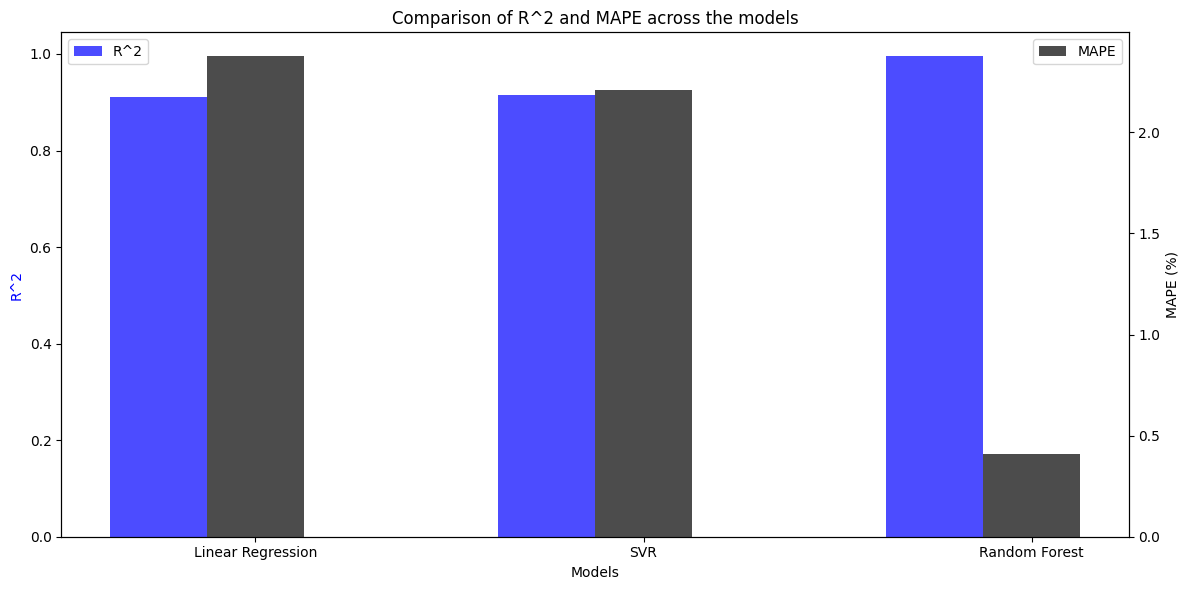

In [28]:
models = ['Linear Regression', 'SVR', 'Random Forest']
r2_scores = [r2_linear, r2_SVR, r2_rf]
mape_scores = [mape_lr, mape_SVR, mape_rf]

fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.25
positions = np.arange(len(models))

# R^2 scores
ax1.bar(positions, r2_scores, bar_width, label="R^2", color="blue", alpha=0.7)

# MAPE scores (on secondary axis)
ax2 = ax1.twinx()
ax2.bar(positions + bar_width, mape_scores, bar_width, label="MAPE", color="black", alpha=0.7)


ax1.set_xlabel("Models")
ax1.set_ylabel("R^2", color="blue")
ax2.set_ylabel("MAPE (%)", color="black")
ax1.set_xticks(positions + bar_width)
ax1.set_xticklabels(models)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Comparison of R^2 and MAPE across the models")

plt.tight_layout()
plt.show()

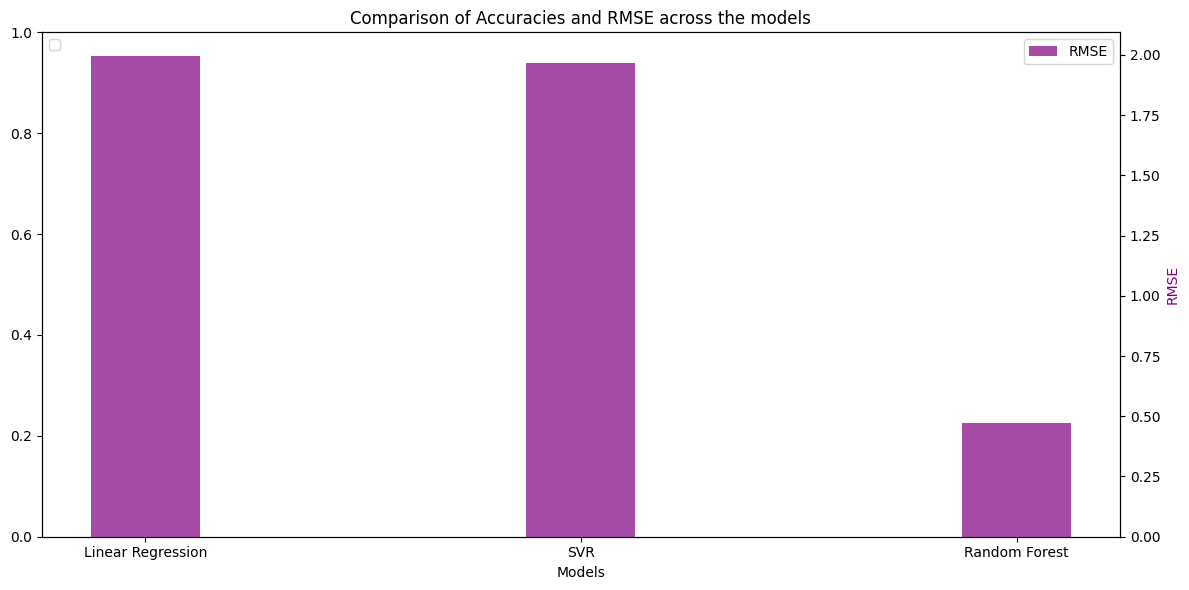

In [29]:
models = ['Linear Regression', 'SVR', 'Random Forest']
rmse = [rmse_lr, rmse_SVR, rmse_rf]
#accuracy = [accuracy_lr, accuracy_SVR, accuracy_rf]

fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.25
positions = np.arange(len(models))

# Accuracy
#ax1.bar(positions + bar_width, accuracy, bar_width, label="Accuracy", color="green", alpha=0.7)

# Custom scores (on secondary axis)
ax2 = ax1.twinx()
ax2.bar(positions + 2 * bar_width, rmse, bar_width, label="RMSE", color="purple", alpha=0.7)

ax1.set_xlabel("Models")
#ax1.set_ylabel("Accuracy", color="green")
ax2.set_ylabel("RMSE", color="purple")
ax1.set_xticks(positions + 2 * bar_width)
ax1.set_xticklabels(models)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Comparison of Accuracies and RMSE across the models")

plt.tight_layout()
plt.show()

## 9. Predicting FIFA 2024 Values

Since Random Forest performed best, we use it to predict player values for the 2024 dataset.

In [30]:
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3,10], 'max_features':
[2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

In [31]:
fifa_2024_predictions = rf_model.predict(X_predict)

# Add predictions to the original FIFA 2024 subset of the dataset
df_2024 = df[df['fifa_version'] == 24].copy()
df_2024['predicted_overall'] = (fifa_2024_predictions).astype(int)

df_2024.head(50)

,player_id,fifa_version,long_name,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,...,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,physic,player_positions,predicted_overall
0,231747,24.0,Kylian Mbappé Lottin,91,94,181500000.0,230000.0,24,182,75,...,5,5,97.0,90.0,80.0,92.0,36.0,78.0,"ST, LW",91
1,239085,24.0,Erling Braut Haaland,91,94,185000000.0,340000.0,22,195,94,...,3,5,89.0,93.0,66.0,80.0,45.0,88.0,ST,91
2,192985,24.0,Kevin De Bruyne,91,91,103000000.0,350000.0,32,181,75,...,4,5,72.0,88.0,94.0,87.0,65.0,78.0,"CM, CAM",90
3,158023,24.0,Lionel Andrés Messi Cuccittini,90,90,41000000.0,23000.0,36,169,67,...,4,5,80.0,87.0,90.0,94.0,33.0,64.0,"CF, CAM",86
4,165153,24.0,Karim Benzema,90,90,51000000.0,95000.0,35,185,81,...,4,5,79.0,88.0,83.0,87.0,39.0,78.0,"CF, ST",86
5,188545,24.0,Robert Lewandowski,90,90,58000000.0,340000.0,34,185,81,...,4,5,75.0,91.0,80.0,87.0,44.0,84.0,ST,90
7,202126,24.0,Harry Kane,90,90,119500000.0,170000.0,29,188,85,...,3,5,69.0,93.0,84.0,83.0,49.0,83.0,ST,88
8,238794,24.0,Vinícius José Paixão de Oliveira Júnior,89,94,158500000.0,310000.0,22,176,73,...,5,5,95.0,82.0,78.0,90.0,29.0,68.0,LW,90
10,231866,24.0,Rodrigo Hernández Cascante,89,90,105500000.0,250000.0,27,191,82,...,3,4,58.0,73.0,80.0,80.0,85.0,84.0,"CDM, CM",88
11,239818,24.0,Rúben dos Santos Gato Alves Dias,89,90,106500000.0,250000.0,26,187,82,...,2,4,62.0,39.0,66.0,69.0,89.0,87.0,CB,87


In [32]:
from scipy import stats

confidence = 0.95
squared_errors = (fifa_2024_predictions - y_predict)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([0.49943496, 0.54448451])

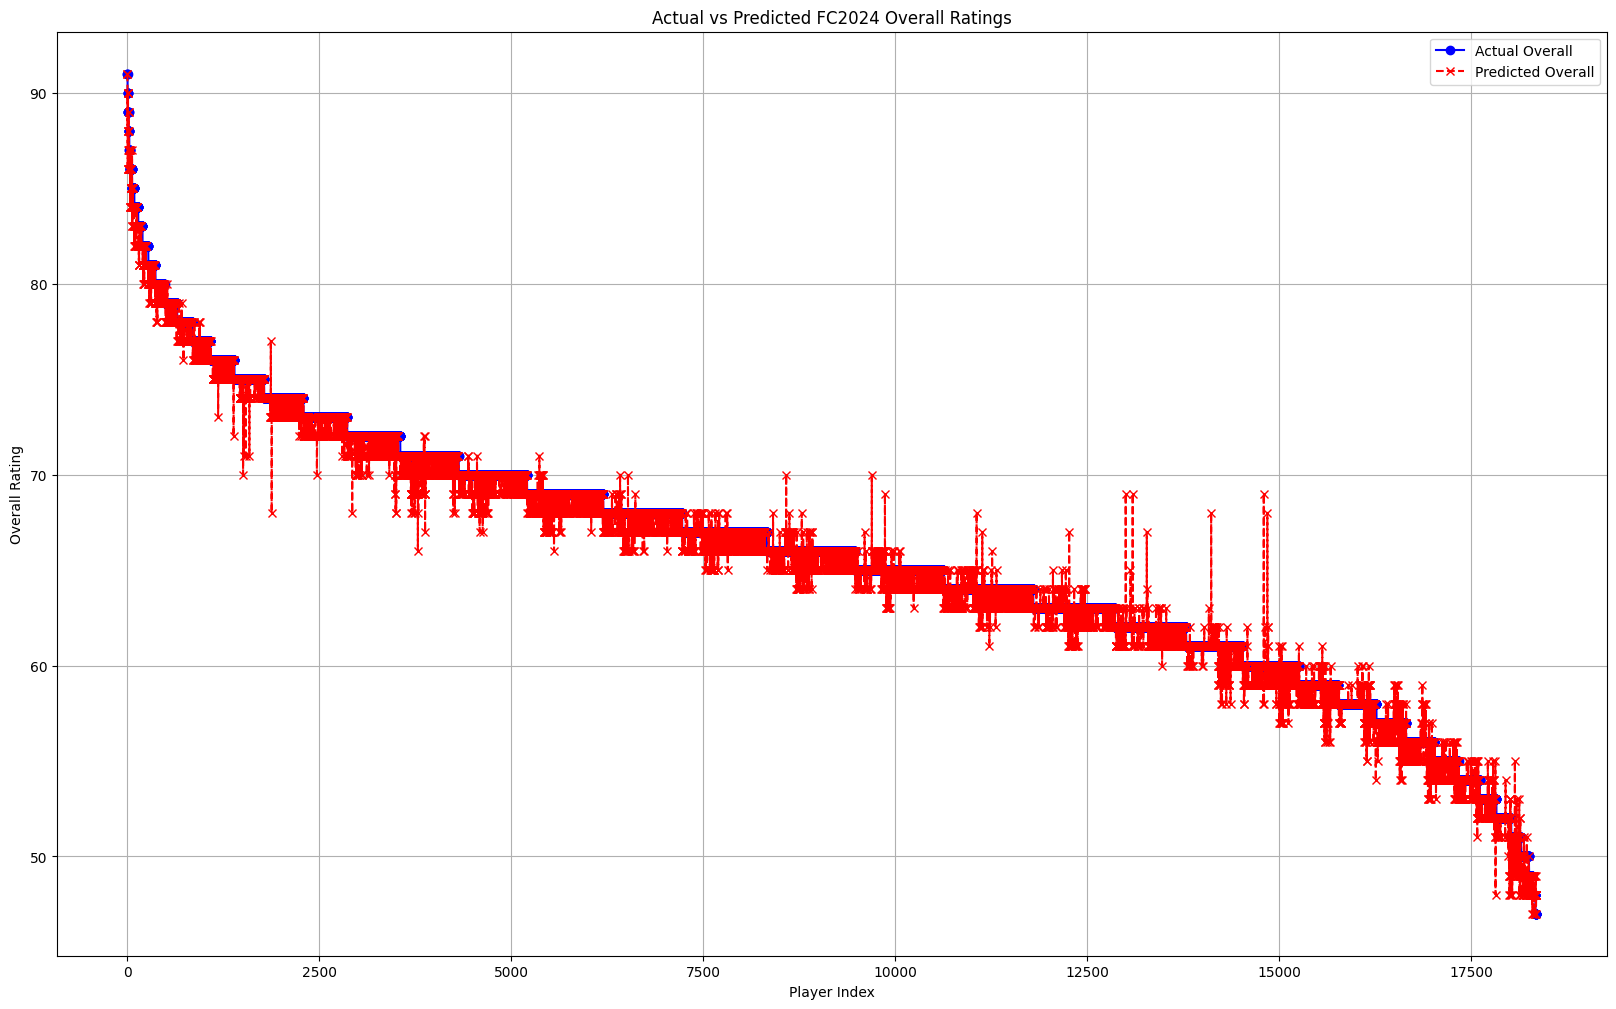

In [33]:
plt.figure(figsize=(20, 12))

# plotting actual values
plt.plot(df_2024['overall'], label='Actual Overall', color='blue', marker='o')

# plotting predicted values
plt.plot(df_2024['predicted_overall'], label='Predicted Overall', color='red', linestyle='--', marker='x')

# Add labels and title
plt.title('Actual vs Predicted FC2024 Overall Ratings')
plt.xlabel('Player Index')
plt.ylabel('Overall Rating')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

## 10. Conclusion

In this project, I used FIFA player data and assessed multiple regression models to predict players' overall rating. Among the tested models, Random Forest Regressor provided the best predictive performance, demonstrating a strong relationship between the chosen features and player overall rating.

The analysis shows that carefully selecting necessary features and using supervised learning methods can creaate predictive model.

The predicted ratings for FIFA 2024 can serve as a useful reference for cyber-athletes, interested parties and gamers in general.